# Project: Wrangling and Analyze Data

In [1]:
import pandas as pd
import numpy as np
from twython import Twython
import requests
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib


## Data Gathering
In the cells below was gathered **all** three pieces of data for this project and loaded them in the notebook. 
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
# Supplied file
archive = pd.read_csv('twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
# Requesting tweet image predictions

with open('image_predictions.tsv' , 'wb') as file:
    image_predictions = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv', auth=('user', 'pass'))
    file.write(image_predictions.content)
    
# Reading image predictions
predictions = pd.read_csv('image_predictions.tsv', sep='\t')

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [4]:
#Use Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file.
import tweepy

consumer_key = '--'
consumer_secret = '--'
access_token = '-----'
access_secret = '--'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)


In [5]:
collected =[]
not_collected = [] 

with open('tweet_json.txt', 'w') as file:
    for tweet_id in list(archive['tweet_id']):
        try:
            tweet_status = api.get_status(tweet_id,tweet_mode='extended')
            json.dump(tweet_status._json, file)
            file.write('\n')
            collected.append(tweet_id)
        except Exception as e:
            not_collected.append(tweet_id)

Rate limit reached. Sleeping for: 294


In [6]:
#Reading JSON content as pandas dataframe
tweets = pd.read_json('tweet_json.txt', lines = True,encoding='utf-8')

## Assessing Data
In this section was detect and documented **nine (9) quality issues and five (5) tidiness issues**. Were use **both** visual assessment programmatic assessement to assess the data.


In [7]:
# Load the data gathered data files
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [8]:
archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [9]:
archive.shape

(2356, 17)

In [10]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [11]:
archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [12]:
# Load the data gathered data files
predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [13]:
predictions.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [14]:
predictions.shape

(2075, 12)

In [15]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [16]:
predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [17]:
# Load the data gathered data files
tweets.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [18]:
tweets.tail()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
2323,2015-11-16 00:24:50+00:00,666049248165822465,666049248165822464,Here we have a 1949 1st generation vulpix. Enj...,False,"[0, 120]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666049244999131136, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2324,2015-11-16 00:04:52+00:00,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2325,2015-11-15 23:21:54+00:00,666033412701032449,666033412701032448,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2326,2015-11-15 23:05:30+00:00,666029285002620928,666029285002620928,This is a western brown Mitsubishi terrier. Up...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666029276303482880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2327,2015-11-15 22:32:08+00:00,666020888022790149,666020888022790144,Here we have a Japanese Irish Setter. Lost eye...,False,"[0, 131]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666020881337073664, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [19]:
tweets.shape

(2328, 32)

In [20]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2328 non-null   datetime64[ns, UTC]
 1   id                             2328 non-null   int64              
 2   id_str                         2328 non-null   int64              
 3   full_text                      2328 non-null   object             
 4   truncated                      2328 non-null   bool               
 5   display_text_range             2328 non-null   object             
 6   entities                       2328 non-null   object             
 7   extended_entities              2058 non-null   object             
 8   source                         2328 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

In [21]:
tweets.describe()

,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,geo,coordinates,contributors,retweet_count,favorite_count,possibly_sensitive,possibly_sensitive_appealable,quoted_status_id,quoted_status_id_str
count,2.328000e+03,2.328000e+03,7.700000e+01,7.700000e+01,7.700000e+01,7.700000e+01,0.0,0.0,0.0,2328.000000,2328.000000,2196.0,2196.0,2.600000e+01,2.600000e+01
mean,7.418403e+17,7.418403e+17,7.440692e+17,7.440692e+17,2.040329e+16,2.040329e+16,NaN,NaN,NaN,2528.426976,7190.622423,0.0,0.0,8.113972e+17,8.113972e+17
std,6.823143e+16,6.823143e+16,7.524295e+16,7.524295e+16,1.260797e+17,1.260797e+17,NaN,NaN,NaN,4280.894132,11169.088371,0.0,0.0,6.295843e+16,6.295843e+16
min,6.660209e+17,6.660209e+17,6.658147e+17,6.658147e+17,1.185634e+07,1.185634e+07,NaN,NaN,NaN,1.000000,0.000000,0.0,0.0,6.721083e+17,6.721083e+17
25%,6.781974e+17,6.781974e+17,6.757073e+17,6.757073e+17,3.589728e+08,3.589728e+08,NaN,NaN,NaN,510.750000,1247.500000,0.0,0.0,7.761338e+17,7.761338e+17
50%,7.180382e+17,7.180382e+17,7.032559e+17,7.032559e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,1177.500000,3111.500000,0.0,0.0,8.281173e+17,8.281173e+17
75%,7.986673e+17,7.986673e+17,8.233264e+17,8.233264e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,2923.750000,8773.750000,0.0,0.0,8.637581e+17,8.637581e+17
max,8.924206e+17,8.924206e+17,8.862664e+17,8.862664e+17,8.405479e+17,8.405479e+17,NaN,NaN,NaN,72466.000000,147738.000000,0.0,0.0,8.860534e+17,8.860534e+17


### Quality issues
#### Archive

1. The timestamp field is in string format (object) and tweet_id is in int64 

2. There are only 181 retweets (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)

3. There are only 78 replies (in_reply_to_status_id, in_reply_to_user_id)

4. There are missing values in the column expanded_urls

5. Column name floofer should be spelled 'floof'

6. Dogs with no name in the description have given names of "a", "an" and "None" instead of "NaN"

7. In the column rating_denominator there are votes greater than 10 

#### Predictions

8. The types of dogs in columns p1, p2, and p3 have some lowercase and uppercase letters

9. The tweet_id field is in int64, should be in string format


### Tidiness issues

#### Archive

1. Rename the column 'id' to 'tweet_id' to facilitate merging

2. Several columns representing the same category, which is divided into "doggo", "flooter", "pupper", "puppo" columns, but we need only one column to represent this classifications

3. Drop unnecessary columns

4. Merge all tables to realize any analysis

5. Clean up text column to show only the text

## Cleaning Data
In this section were clean up **all** of the issues you documented while assessing. 

In [27]:
# Make copies of original pieces of data
archive_clean = archive.copy()
predictions_clean = predictions.copy()
tweets_clean = tweets.copy()

### Quality issues

### Issue #1: Erroneous data types

#### Define: The timestamp field is in string format (object) and tweet_id is in int64

#### Code

In [28]:
#change the dtype of column timestamp from object to datetime
archive_clean.timestamp = archive_clean.timestamp.astype('datetime64')
archive_clean.tweet_id = archive_clean.tweet_id.astype(str)

#### Test

In [29]:
#Check for changes
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   object        
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2297 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

### Issue #2: Missing records 

#### Define: There are only 181 retweets (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)

#### Code

In [30]:
#Use drop function to drop the non necessary columns
archive_clean = archive_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

#### Test

In [31]:
#Check for changes
archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Issue #3: Missing records 

#### Define: There are only 78 replies (in_reply_to_status_id, in_reply_to_user_id)

#### Code

In [32]:
#Use drop function to drop the non necessary columns
archive_clean = archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis=1)

#### Test

In [33]:
#Check for changes
archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Issue #4: Missing records 

#### Define: There are missing values in the column expanded_urls

#### Code

In [34]:
#Use drop function to drop the  expanded_urls. We wont use this column for the analysis
archive_clean = archive_clean.drop(['expanded_urls'], axis=1)

#### Test

In [35]:
#Check for changes
archive_clean.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None


### Issue #5: Correct the column name

#### Define: Column name floofer should be spelled 'floof'

#### Code

In [36]:
# Rename the column 'floofer'
archive_clean = archive_clean.rename(columns={'floofer':'floof'})

#### Test

In [37]:
#Check for changes
archive_clean.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floof,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None


### Issue #6: Differents inputs for the same categories 

#### Define: Dogs with no name in the description have given names of "a", "an"  and "None" instead of "NaN"

#### Code

In [38]:
# Replace the value 'None' with NaN 
archive_clean =  archive_clean.replace('None', np.nan)
archive_clean =  archive_clean.replace('a', np.nan)
archive_clean =  archive_clean.replace('an', np.nan)

#### Test

In [39]:
#Check for changes
archive_clean.name.value_counts()

Charlie     12
Cooper      11
Lucy        11
Oliver      11
Lola        10
            ..
Furzey       1
Severus      1
Spark        1
Damon        1
Philippe     1
Name: name, Length: 954, dtype: int64

### Issue #7: There are no delimitations for the rating demonimator

#### Define: In the column rating_denominator there are votes greater than 10

#### Code

In [40]:
#Select only the values in the column rating_denominator that should only be "10"
archive_clean.rating_denominator = archive_clean[archive_clean.rating_denominator == 10]

#### Test

In [41]:
#Check for changes
archive_clean

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floof,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,892420643555336193,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,892177421306343426,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,891815181378084864,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,891689557279858688,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,891327558926688256,Franklin,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,2015-11-16 00:24:50,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,5,666049248165822465,NaN,NaN,NaN,NaN,NaN
2352,666044226329800704,2015-11-16 00:04:52,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,6,666044226329800704,NaN,NaN,NaN,NaN,NaN
2353,666033412701032449,2015-11-15 23:21:54,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,9,666033412701032449,NaN,NaN,NaN,NaN,NaN
2354,666029285002620928,2015-11-15 23:05:30,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,7,666029285002620928,NaN,NaN,NaN,NaN,NaN


### Issue #8: Differents letter cases

#### Define: The types of dogs in columns p1, p2, and p3 have some lowercase and uppercase letters

#### Code

In [42]:
#Convert all the dogs names to lowercase letters
predictions_clean['p1'] = predictions_clean['p1'].str.lower()
predictions_clean['p2'] = predictions_clean['p2'].str.lower()
predictions_clean['p3'] = predictions_clean['p3'].str.lower()

#### Test

In [43]:
#Check for changes
predictions_clean.p1.head()

0    welsh_springer_spaniel
1                   redbone
2           german_shepherd
3       rhodesian_ridgeback
4        miniature_pinscher
Name: p1, dtype: object

### Issue #8: Differents letter cases

#### Define: The tweet_id field is in int64, should be in string format

#### Code

In [44]:
#change the dtype of column tweed_id from int64 to string format
predictions_clean.tweet_id = predictions_clean.tweet_id.astype(str)
tweets_clean.id = tweets_clean.id.astype(str)

#### Test

In [45]:
#Check for changes
predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [46]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2328 non-null   datetime64[ns, UTC]
 1   id                             2328 non-null   object             
 2   id_str                         2328 non-null   int64              
 3   full_text                      2328 non-null   object             
 4   truncated                      2328 non-null   bool               
 5   display_text_range             2328 non-null   object             
 6   entities                       2328 non-null   object             
 7   extended_entities              2058 non-null   object             
 8   source                         2328 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

### Tidiness issues

### Issue #1: Differents columns names for the same content

#### Define: Rename the column 'id' to 'tweet_id' to facilitate merging

#### Code

In [47]:
#Use rename() function to rename the column
tweets_clean = tweets_clean.rename(columns={'id':'tweet_id'})

#### Test

In [48]:
#Check for changes
tweets_clean.head()

,created_at,tweet_id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


### Issue #2:  Unify the dogs classes

#### Define: Several columns representing the same category, which is divided into "doggo", "flooter", "pupper", "puppo" columns, but we need only one column to represent this classifications

#### Code

In [49]:
#Use loc function to add a new column to represent the dog stage 
archive_clean.loc[archive_clean['doggo'] == 'doggo', 'stage'] = 'doggo'
archive_clean.loc[archive_clean['floof'] == 'floof', 'stage'] = 'floof'
archive_clean.loc[archive_clean['pupper'] == 'pupper', 'stage'] = 'pupper'
archive_clean.loc[archive_clean['puppo'] == 'puppo', 'stage'] = 'puppo'

#### Test

In [50]:
#Check for changes
archive_clean.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floof,pupper,puppo,stage
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,892420643555336193,Phineas,NaN,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,892177421306343426,Tilly,NaN,NaN,NaN,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,891815181378084864,Archie,NaN,NaN,NaN,NaN,NaN
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,891689557279858688,Darla,NaN,NaN,NaN,NaN,NaN
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,891327558926688256,Franklin,NaN,NaN,NaN,NaN,NaN


#### Code

In [51]:
#Dropping the columns: doggo, floofer, pupper and poppo
archive_clean = archive_clean.drop(['doggo', 'floof', 'pupper', 'puppo'], axis = 1)

#### Test

In [52]:
#Check the final change in the dogs stages
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2356 non-null   object        
 1   timestamp           2356 non-null   datetime64[ns]
 2   source              2356 non-null   object        
 3   text                2356 non-null   object        
 4   rating_numerator    2356 non-null   int64         
 5   rating_denominator  2333 non-null   object        
 6   name                1549 non-null   object        
 7   stage               371 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 147.4+ KB


### Issue #3: Unnecessary columns

#### Define: Drop unnecessary columns

#### Code

In [53]:
#Use drop function to drop source column
archive_clean.drop(columns='source', inplace=True)

#### Test

In [54]:
#Check for change 
archive_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stage
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,13,892420643555336193,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,13,892177421306343426,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,12,891815181378084864,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,13,891689557279858688,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,12,891327558926688256,Franklin,NaN


### Issue #4: Separated tables

#### Define: Merge all tables to realize any analysis

#### Code

In [55]:
#Merge the archive_clean and tweets_clean table
merge_df = archive_clean.join(tweets_clean.set_index('tweet_id'), on='tweet_id')
merge_df.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stage,created_at,id_str,full_text,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,13,892420643555336193,Phineas,NaN,2017-08-01 16:23:56+00:00,8.924206e+17,This is Phineas. He's a mystical boy. Only eve...,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,13,892177421306343426,Tilly,NaN,2017-08-01 00:17:27+00:00,8.921774e+17,This is Tilly. She's just checking pup on you....,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,12,891815181378084864,Archie,NaN,2017-07-31 00:18:03+00:00,8.918152e+17,This is Archie. He is a rare Norwegian Pouncin...,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,13,891689557279858688,Darla,NaN,2017-07-30 15:58:51+00:00,8.916896e+17,This is Darla. She commenced a snooze mid meal...,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,12,891327558926688256,Franklin,NaN,2017-07-29 16:00:24+00:00,8.913276e+17,This is Franklin. He would like you to stop ca...,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


#### Test

In [56]:
#Check the new df
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2356 non-null   object             
 1   timestamp                      2356 non-null   datetime64[ns]     
 2   text                           2356 non-null   object             
 3   rating_numerator               2356 non-null   int64              
 4   rating_denominator             2333 non-null   object             
 5   name                           1549 non-null   object             
 6   stage                          371 non-null    object             
 7   created_at                     2328 non-null   datetime64[ns, UTC]
 8   id_str                         2328 non-null   float64            
 9   full_text                      2328 non-null   object             
 10  truncated               

In [57]:
#Join the merge_df to the predictions_clean table
twitter_master = merge_df.join(predictions_clean.set_index('tweet_id'), on='tweet_id')
twitter_master.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stage,created_at,id_str,full_text,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,13,892420643555336193,Phineas,NaN,2017-08-01 16:23:56+00:00,8.924206e+17,This is Phineas. He's a mystical boy. Only eve...,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,13,892177421306343426,Tilly,NaN,2017-08-01 00:17:27+00:00,8.921774e+17,This is Tilly. She's just checking pup on you....,...,1.0,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,12,891815181378084864,Archie,NaN,2017-07-31 00:18:03+00:00,8.918152e+17,This is Archie. He is a rare Norwegian Pouncin...,...,1.0,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,13,891689557279858688,Darla,NaN,2017-07-30 15:58:51+00:00,8.916896e+17,This is Darla. She commenced a snooze mid meal...,...,1.0,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,12,891327558926688256,Franklin,NaN,2017-07-29 16:00:24+00:00,8.913276e+17,This is Franklin. He would like you to stop ca...,...,2.0,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True


In [58]:
twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2356 non-null   object             
 1   timestamp                      2356 non-null   datetime64[ns]     
 2   text                           2356 non-null   object             
 3   rating_numerator               2356 non-null   int64              
 4   rating_denominator             2333 non-null   object             
 5   name                           1549 non-null   object             
 6   stage                          371 non-null    object             
 7   created_at                     2328 non-null   datetime64[ns, UTC]
 8   id_str                         2328 non-null   float64            
 9   full_text                      2328 non-null   object             
 10  truncated               

#### Code

In [59]:
#Filter the columns to further analisys
twitter_master_clean = twitter_master.filter(['tweet_id','timestamp','text', 'rating_numerator', 'rating_denominator','name','stage','retweet_count', 'favorite_count', 'jpg_url','img_num', 'p1', 'p1_conf','p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'])
twitter_master_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,13,892420643555336193,Phineas,NaN,7167.0,34447.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,13,892177421306343426,Tilly,NaN,5387.0,29861.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,12,891815181378084864,Archie,NaN,3552.0,22486.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,13,891689557279858688,Darla,NaN,7380.0,37639.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,12,891327558926688256,Franklin,NaN,7924.0,35957.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True


### Issue #5: Column Text has multiples variables

#### Define: Clean up text column to show only the text

#### Code

In [60]:
#Remove url link
twitter_master_clean['text'] = twitter_master_clean.text.str.replace(r"http\S+", "")
twitter_master_clean['text'] = twitter_master_clean.text.str.strip()

<ipython-input-60-03d22a733293>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  twitter_master_clean['text'] = twitter_master_clean.text.str.replace(r"http\S+", "")


#### Test

In [61]:
twitter_master_clean['text'][0]

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10"

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [62]:
#store data with to_csv function
twitter_master_clean.to_csv('twitter_archive_master.csv', index = False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [63]:
#Make a copy
rate_dogs = twitter_master_clean.copy()

In [64]:
rate_dogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2356 non-null   object        
 1   timestamp           2356 non-null   datetime64[ns]
 2   text                2356 non-null   object        
 3   rating_numerator    2356 non-null   int64         
 4   rating_denominator  2333 non-null   object        
 5   name                1549 non-null   object        
 6   stage               371 non-null    object        
 7   retweet_count       2328 non-null   float64       
 8   favorite_count      2328 non-null   float64       
 9   jpg_url             2075 non-null   object        
 10  img_num             2075 non-null   float64       
 11  p1                  2075 non-null   object        
 12  p1_conf             2075 non-null   float64       
 13  p1_dog              2075 non-null   object      

In [65]:
#Select missing values from table merged to drop later
drop = rate_dogs[pd.isnull(rate_dogs['retweet_count'])].index
drop1 = rate_dogs[pd.isnull(rate_dogs['jpg_url'])].index
drop, drop1

(Int64Index([  19,   95,  101,  104,  118,  132,  155,  182,  185,  211,  247,
              253,  260,  296,  298,  363,  382,  506,  566,  750,  784,  815,
              818,  841,  887,  890,  932, 1726],
            dtype='int64'),
 Int64Index([  30,   32,   35,   42,   55,   64,   68,   72,   73,   74,
             ...
             1895, 1905, 1914, 1916, 1940, 2038, 2149, 2189, 2212, 2298],
            dtype='int64', length=281))

In [66]:
#Drop missing data from merged table
rate_dogs.drop(index=drop, inplace=True)
rate_dogs.drop(index=drop1, inplace=True)

KeyError: '[101 118 132 182 185 247 382 506 784 818 841] not found in axis'

In [67]:
#Check the changes
rate_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2355
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2328 non-null   object        
 1   timestamp           2328 non-null   datetime64[ns]
 2   text                2328 non-null   object        
 3   rating_numerator    2328 non-null   int64         
 4   rating_denominator  2306 non-null   object        
 5   name                1533 non-null   object        
 6   stage               366 non-null    object        
 7   retweet_count       2328 non-null   float64       
 8   favorite_count      2328 non-null   float64       
 9   jpg_url             2058 non-null   object        
 10  img_num             2058 non-null   float64       
 11  p1                  2058 non-null   object        
 12  p1_conf             2058 non-null   float64       
 13  p1_dog              2058 non-null   object      

In [68]:
#Investigating the time of the tweets
rate_dogs.timestamp.min(), rate_dogs.timestamp.max()

(Timestamp('2015-11-15 22:32:08'), Timestamp('2017-08-01 16:23:56'))

In [69]:
#Set the index to the datatime 
rate_dogs = rate_dogs.set_index('timestamp')

In [70]:
#Look for informations
rate_dogs.describe()

,rating_numerator,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf
count,2328.000000,2328.000000,2328.000000,2058.000000,2058.000000,2.058000e+03,2.058000e+03
mean,13.137027,2528.426976,7190.622423,1.204082,0.594307,1.347671e-01,6.041724e-02
std,46.151473,4280.894132,11169.088371,0.563121,0.271161,1.007171e-01,5.098970e-02
min,0.000000,1.000000,0.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,10.000000,510.750000,1247.500000,1.000000,0.363478,5.393987e-02,1.624755e-02
50%,11.000000,1177.500000,3111.500000,1.000000,0.587797,1.186345e-01,4.947920e-02
75%,12.000000,2923.750000,8773.750000,1.000000,0.843883,1.958557e-01,9.218437e-02
max,1776.000000,72466.000000,147738.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


In [83]:
rate_dogs.favorite_count.max()/rate_dogs.retweet_count.max()

2.0387216073744927

In [71]:
#See if there is any correlations
rate_dogs.corr()

,rating_numerator,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf
rating_numerator,1.000000,0.003965,0.005056,-0.000427,-0.009097,-0.020455,-0.003939
retweet_count,0.003965,1.000000,0.801396,0.105869,0.043862,-0.004684,-0.031911
favorite_count,0.005056,0.801396,1.000000,0.125254,0.067283,-0.017860,-0.046988
img_num,-0.000427,0.105869,0.125254,1.000000,0.203972,-0.160361,-0.139401
p1_conf,-0.009097,0.043862,0.067283,0.203972,1.000000,-0.512227,-0.708975
p2_conf,-0.020455,-0.004684,-0.017860,-0.160361,-0.512227,1.000000,0.480346
p3_conf,-0.003939,-0.031911,-0.046988,-0.139401,-0.708975,0.480346,1.000000


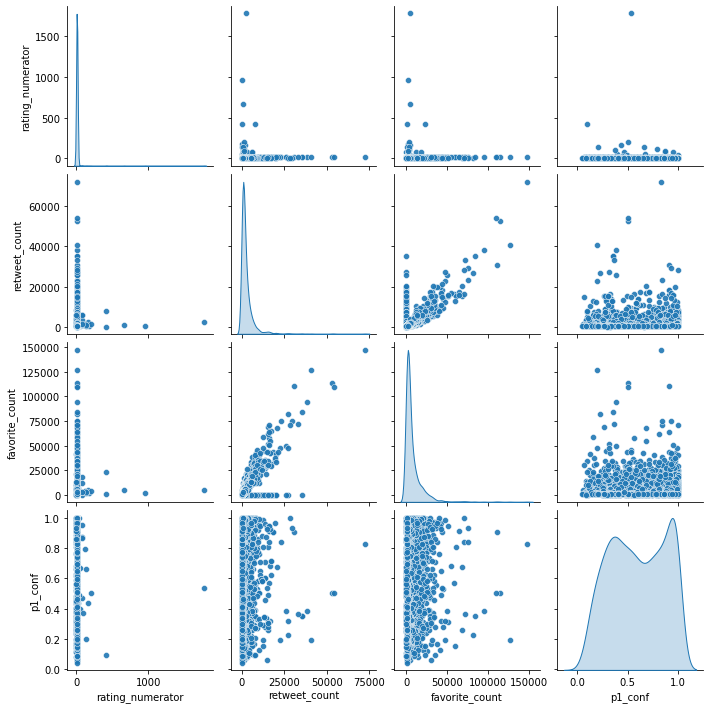

In [72]:
#Plot the correlations
sns.pairplot(rate_dogs, 
             vars = ['rating_numerator', 'retweet_count', 'favorite_count', 'p1_conf'], 
             diag_kind = 'kde', plot_kws = {'alpha': 0.9});

In [73]:
#Check the most favorited tweet
rate_dogs.sort_values(by = 'favorite_count', ascending = False).head(3)

,tweet_id,text,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
timestamp,,,,,,,,,,,,,,,,,,,
2016-06-18 18:26:18,744234799360020481,Here's a doggo realizing you can stand in a po...,13,744234799360020481,NaN,doggo,72466.0,147738.0,https://pbs.twimg.com/ext_tw_video_thumb/74423...,1.0,labrador_retriever,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True
2017-01-21 18:26:02,822872901745569793,Here's a super supportive puppo participating ...,13,822872901745569793,NaN,puppo,40916.0,126464.0,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,1.0,lakeland_terrier,0.196015,True,labrador_retriever,0.160329,True,irish_terrier,0.069126,True
2016-12-09 06:17:20,807106840509214720,This is Stephan. He just wants to help. 13/10 ...,13,807106840509214720,Stephan,NaN,52926.0,114152.0,https://pbs.twimg.com/ext_tw_video_thumb/80710...,1.0,chihuahua,0.505370,True,pomeranian,0.120358,True,toy_terrier,0.077008,True


In [74]:
#Check the most retweeted tweet
rate_dogs.sort_values(by = 'retweet_count', ascending = False).head(3)

,tweet_id,text,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
timestamp,,,,,,,,,,,,,,,,,,,
2016-06-18 18:26:18,744234799360020481,Here's a doggo realizing you can stand in a po...,13,744234799360020481,NaN,doggo,72466.0,147738.0,https://pbs.twimg.com/ext_tw_video_thumb/74423...,1.0,labrador_retriever,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True
2016-06-04 23:31:25,739238157791694849,Here's a doggo blowing bubbles. It's downright...,13,739238157791694849,NaN,doggo,54106.0,109338.0,https://pbs.twimg.com/ext_tw_video_thumb/73923...,1.0,eskimo_dog,0.503372,True,siberian_husky,0.390413,True,malamute,0.080901,True
2016-12-09 06:17:20,807106840509214720,This is Stephan. He just wants to help. 13/10 ...,13,807106840509214720,Stephan,NaN,52926.0,114152.0,https://pbs.twimg.com/ext_tw_video_thumb/80710...,1.0,chihuahua,0.505370,True,pomeranian,0.120358,True,toy_terrier,0.077008,True


In [75]:
#Check fot the most common dogs stages
rate_dogs.stage.value_counts()

pupper    255
doggo      81
puppo      30
Name: stage, dtype: int64

In [76]:
#Check for the most common dogs breeds 
rate_dogs.p1.value_counts().head(10)

golden_retriever      150
labrador_retriever     96
pembroke               88
chihuahua              81
pug                    57
chow                   44
samoyed                42
toy_poodle             38
pomeranian             38
cocker_spaniel         30
Name: p1, dtype: int64

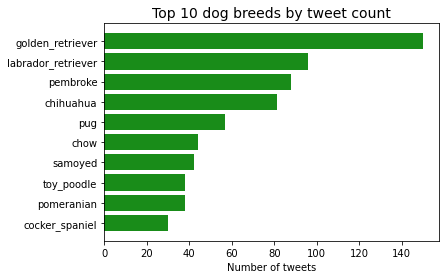

In [77]:
#Plot the most common dogs breeds 
plt.barh(rate_dogs.p1.value_counts().head(10).index, rate_dogs.p1.value_counts().head(10), color = 'g',  alpha=0.9)
plt.xlabel('Number of tweets', fontsize = 10)
plt.title('Top 10 dog breeds by tweet count', fontsize = 14)
plt.gca().invert_yaxis()
plt.show();

In [78]:
#Group favorite count with dogs breeds and see what are the most favorites
top10 = rate_dogs.favorite_count.groupby(rate_dogs['p1']).sum().sort_values(ascending = False)
top10.head(10)

p1
golden_retriever      1505135.0
labrador_retriever     928971.0
pembroke               884670.0
chihuahua              610912.0
samoyed                456587.0
french_bulldog         416451.0
chow                   360605.0
pug                    276947.0
cocker_spaniel         273544.0
pomeranian             269766.0
Name: favorite_count, dtype: float64

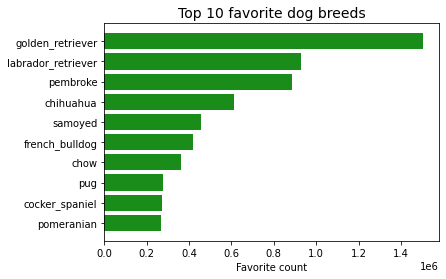

In [79]:
#Plot the most favorites dogs breeds 
plt.barh(top10.head(10).index, top10.head(10), color = 'g', alpha=0.9)
plt.xlabel('Favorite count', fontsize = 10)
plt.title('Top 10 favorite dog breeds', fontsize = 14)
plt.gca().invert_yaxis()
plt.show();

Text(0.5, 1.0, 'Average favorite counts by dogs stages')

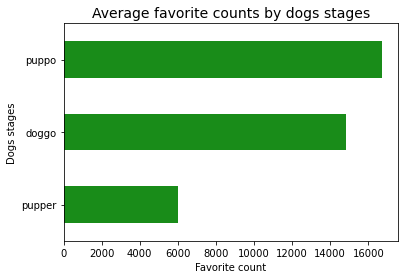

In [80]:
#Plot the most favorites dogs stages
favorite_count_stages = rate_dogs.groupby('stage').favorite_count.mean().sort_values()
favorite_count_stages.plot(x="stage",y='favorite_count',kind='barh',color='g', alpha=0.9)
plt.xlabel('Favorite count', fontsize = 10)
plt.ylabel('Dogs stages', fontsize = 10)
plt.title('Average favorite counts by dogs stages', fontsize = 14)

### Insights:
1.  The quantity of people who favorite the posts is 2.039 time higher than people that retweet the posts. This shows a preference of just favorite the posts than retweet.

2. There are a strong correlation between the favorites counts and retweets. To be more precised the correlation is 0.801345.
To evidenciate better, the most retweeted and favorited dog is a doggo labrador retriever who received 72474 retweets and 147742 favorites votes. His ID is 744234799360020481.

3. The most common dogs breeds are golden retriever, labrador retriever and pembroke, respectively. They receive the most favorite counts too.


### Visualizations

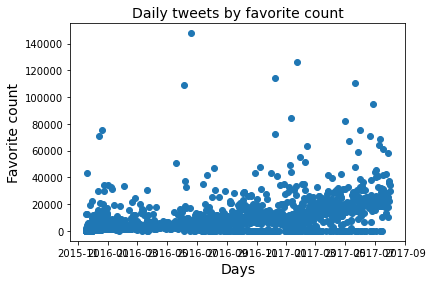

In [81]:
#Plot a scatter plot to verify a possible trend in the amount os favorite count over time
plt.scatter(rate_dogs.index, rate_dogs['favorite_count'])
plt.title('Daily tweets by favorite count', fontsize = 14)
plt.xlabel('Days', fontsize = 14)
plt.ylabel('Favorite count', fontsize = 14)
plt.show();

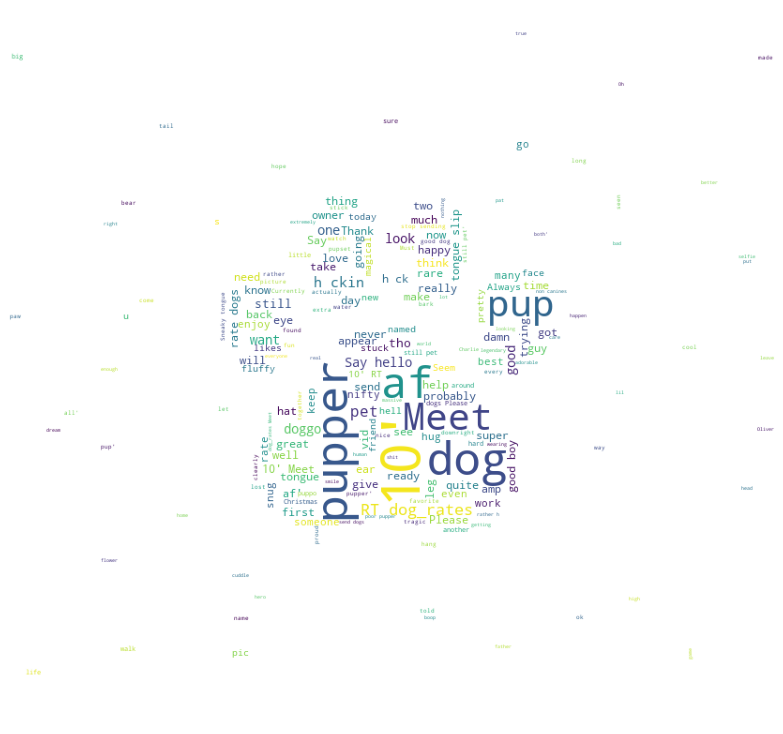

In [85]:
#Plot a Word Cloud with the texts written

tweets = np.array(rate_dogs.text)
list1 = []
for tweet in tweets:
    list1.append(tweet.replace("\n",""))
    
    
    
mask = np.array(Image.open(requests.get('https://img.favpng.com/23/21/16/dog-vector-graphics-bengal-cat-illustration-clip-art-png-favpng-RWmY6zWcLaCxWurMaPEpZpARA.jpg', stream=True).raw))
text = list1




def gen_wc(text, mask):
    word_cloud = WordCloud(width = 700, height = 400, background_color='white', mask=mask).generate(str(text))
    plt.figure(figsize=(16,10),facecolor = 'white', edgecolor='red')
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    
    
    
    
gen_wc(text, mask)

# The code used above was modeled from this blog on how to generate a word cloud in python.
#https://blog.goodaudience.com/how-to-generate-a-word-cloud-of-any-shape-in-python-7bce27a55f6e

### Insights:

1. We can have a visual look in the Daily tweets by favorite count chart and verify a positive trend in the amount of favorite tweets over time.

2. In the cloud chart we can see that the word  pooper, dog, pup and meet are the most frequently written.